In [111]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [41]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [42]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [50]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values
labels_y = df.loc[:, 'bulk_labels']

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y, labels_y = X[permutation], y[permutation], labels_y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


/var/folders/rj/9rycj1kx7216zcx0fpf1_9p40000gn/T/ipykernel_12175/2298712832.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X, y, labels_y = X[permutation], y[permutation], labels_y[permutation]


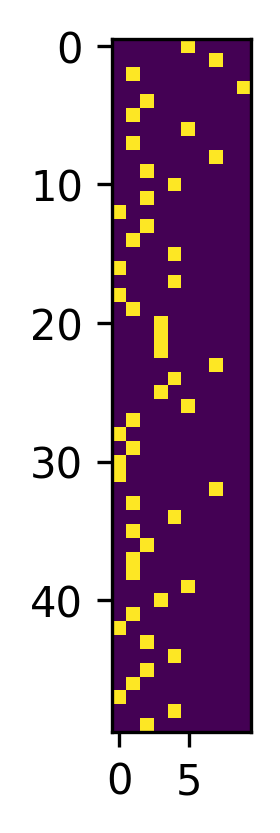

In [51]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [61]:
#FF Neural Network 
class PBMC_Network(nn.Module):
    def __init__(self):
        super().__init__()

        """
        Define your layers here.
        """
        in_out_dim = 765
        latent_space = 32

        self.input_layer = nn.Linear(in_out_dim, 128)
        self.hidden_enc1 = nn.Linear(128, 64)
        self.hidden_enc2 = nn.Linear(64, latent_space)
        self.output_layer = nn.Linear(latent_space, 10)
        

    def forward(self, X):

        """
        Design the process of your network.
        """
        X = self.input_layer(X)
        X = F.relu(X)

        X = self.hidden_enc1(X)
        X = F.relu(X)

        X = self.hidden_enc2(X)
        X = F.relu(X)

        logits = self.output_layer(X)
        return logits
    
    def classify(self, X):
         """
        Q:  create a function classify that will take in X data points and produce
            the predicted classification of these points.

        HINT: use torch.softmax() and torch.argmax()! you NEED them.

        Inputs
        - X: the torch.tensor matrix to be classified with shape (N, D)

        Outputs
        - labels: a torch.tensor with the shape (N, ), each item being X[i]'s
                  classification prediction
        """
         X = torch.tensor(X).type(torch.float32)     # enforce smooth-running with the model
         logits = self(X)    #array of numbers that correspond to each class representing the output layer
         y = torch.softmax(logits, dim=1)  #pass the elements of the output layer in the activation function; dim: 0 each col sums to 1 and dim: 1 each row sums to 1 (each column is a class, so we want the probability of each class by doing dim = 1)
         labels = torch.argmax(y, dim=1)
         return labels.type(torch.long)

In [72]:
model = PBMC_Network()
X_train_tens, y_train_tens = torch.tensor(X_train).type(torch.float32), torch.tensor(y_train).type(torch.long)
X_test_tens, y_test_tens = torch.tensor(X_test).type(torch.float32), torch.tensor(y_test).type(torch.long)
out = model(X_train_tens[:2])
out.shape

torch.Size([2, 10])

In [69]:
X_train_tens[:2], y_train_tens[:2]

(tensor([[-0.3260, -0.1910, -0.7280,  ..., -0.2100, -0.6360, -0.4900],
         [-0.3260, -0.1910, -0.7280,  ..., -0.2100,  2.1340, -0.4900]]),
 tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))

In [80]:
model.classify(X_train_tens[:2])

/var/folders/rj/9rycj1kx7216zcx0fpf1_9p40000gn/T/ipykernel_12175/2399466848.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float32)     # enforce smooth-running with the model


tensor([5, 4])

In [105]:
def train(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=32, lr=1e-3):
    """
    Q:  write the training loop following the schema shown above.

    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - X_train, y_train, X_val, y_val: training and validation data
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate
    - optimizer: optimizer used

    Outputs
    - losses: a list of losses
    - accuracies: a list of validation accuracies
    - train_accs: a list of training accuracies
    """

    batches = int(X_train.shape[0] / batch_size)  # # using batch_size, determine the number of batches needed

    loss_fn = nn.CrossEntropyLoss()                             # read the write-up for an explanation on CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)     # read the write-up for an explanation on Adam

    losses = []
    train_accs = []
    accuracies = []

    for epoch in range(epochs):
        for i in range(batches):
            X_batch = X_train[i * batch_size: i * batch_size + batch_size] #
            y_batch = y_train[i * batch_size: i * batch_size + batch_size] #

            logits = model(X_batch) 

            loss = loss_fn(logits, y_batch.float())


            # these 3 functions will follow you whenever you train a model with PyTorch
            optimizer.zero_grad()   # erases the gradients from the previous epoch (sets all gradients to 0)
            loss.backward()         # calculates the gradients with respect to every single weight matrix in the model
            optimizer.step()        # takes ONE learning step with the gradients just calculated

        # feel free to use sklearn's accuracy_score function
        # calculate the training accuracy

        y_train_arg = torch.argmax(y_train, dim=1)
        y_val_arg = torch.argmax(y_val, dim=1)

        train_accs = np.append(train_accs, accuracy_score(model.classify(X_train), y_train_arg)) #
        accuracy = train_accs[-1]

        # calculate the validation accuracy and append the loss of this epoch

        accuracies = np.append(accuracies, accuracy_score(model.classify(X_val), y_val_arg))

        losses = np.append(losses, loss_fn(model(X_val), y_val.float()).detach().numpy())

        # print epoch, loss, and current test accuracy
        print(f"Epoch {epoch}:\tloss {loss} & accuracy {accuracy}")

    return losses, accuracies, train_accs

In [106]:
losses, accuracies, train_accs = train(model, X_train_tens, y_train_tens, X_test_tens, y_test_tens, epochs=5)

Epoch 0:	loss 0.008180826902389526 & accuracy 0.9928571428571429
Epoch 1:	loss 0.0011855708435177803 & accuracy 0.9946428571428572
Epoch 2:	loss 5.0674676458584145e-05 & accuracy 0.9910714285714286
Epoch 3:	loss 2.5179944714182056e-05 & accuracy 0.9928571428571429
Epoch 4:	loss 2.3131751731853e-05 & accuracy 0.9928571428571429


/var/folders/rj/9rycj1kx7216zcx0fpf1_9p40000gn/T/ipykernel_12175/2399466848.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float32)     # enforce smooth-running with the model
/var/folders/rj/9rycj1kx7216zcx0fpf1_9p40000gn/T/ipykernel_12175/2399466848.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float32)     # enforce smooth-running with the model
/var/folders/rj/9rycj1kx7216zcx0fpf1_9p40000gn/T/ipykernel_12175/2399466848.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

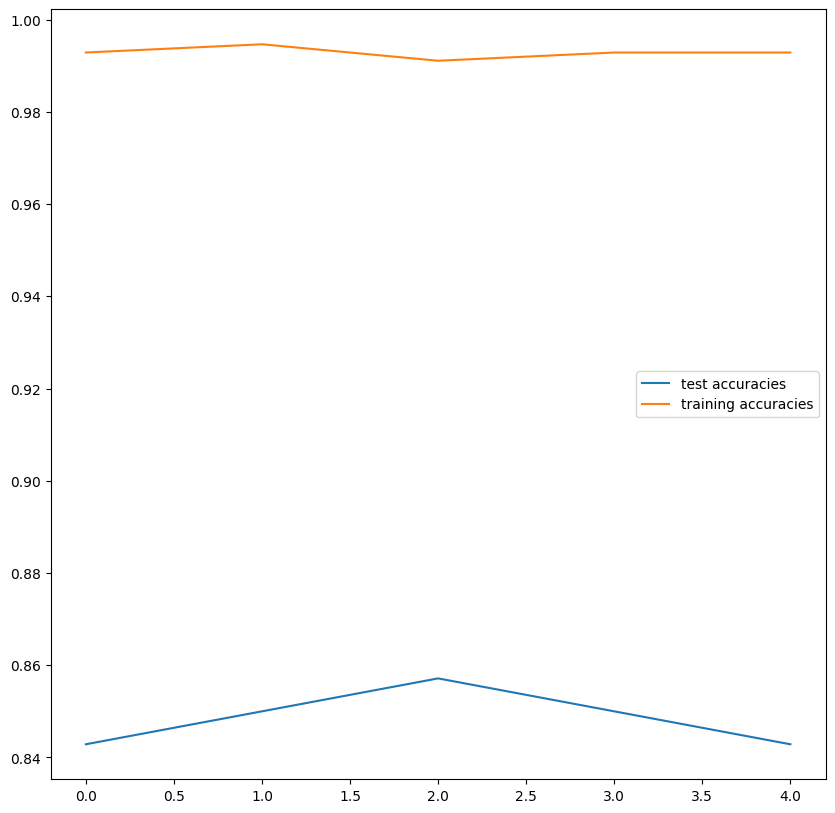

In [116]:
def graph(accuracies, training_accs):
    """
    Q:  graph out the accuracies and training accuracies.
        make sure you label which curve is the validation/training accuracy.
        labels and titles are required.

    Inputs
    - accuracies: list of floats with length epochs
    - training_accs: list of floats with length epochs

    Outputs
    - None
    """
    plt.figure(figsize=(10,10))
    sns.lineplot(
        x=np.arange(5), y=accuracies, label="test accuracies"
    )
    sns.lineplot(
        x=np.arange(5), y=training_accs, label="training accuracies"
    )
    


graph(accuracies, train_accs)